In [1]:
using Revise
using TransportBasedInference
using HierarchicalDA
using LinearAlgebra
using OrdinaryDiffEq
using Trixi
using FFTW
using DifferentialEquations
using Distributions
using Statistics
using SparseArrays
using LinearMaps

Precompiling HierarchicalDA
  ✓ HierarchicalDA
  1 dependency successfully precompiled in 7 seconds. 500 already precompiled.


In [2]:
using CairoMakie
using LaTeXStrings
# using Plots

In [3]:
polydeg = 3
Ncells = 100

Nx = (polydeg+1)*Ncells
Δ = 20
Ny = ceil(Int64, Nx/Δ)

# Define Trixi system for inviscid Burgers equation
sys_burgers = setup_burgers(polydeg, Ncells);

xgrid = vec(sys_burgers.mesh.md.xq);

Define polynomial annihilator operator

In [4]:
order_PA = 3

Ns = Nx - 2*ceil(Int64, order_PA/2)

PA = PolyAnnil(xgrid, order_PA; istruncated = true)

@assert size(PA.P) == (Ns, Nx)

S = LinearMaps.FunctionMap{Float64,true}((s,x)->mul!(s, PA.P, x), (x,s)->mul!(x, PA.P', s),
Ns, Nx; issymmetric=false, isposdef=false)

xs = xgrid[ceil(Int64, order_PA/2)+1:end-ceil(Int64, order_PA/2)]

396-element Vector{Float64}:
 -0.9866001895641519
 -0.9813886368840595
 -0.9786113631159403
 -0.9733998104358488
 -0.9666001895641518
 -0.9613886368840595
 -0.9586113631159403
 -0.9533998104358486
 -0.9466001895641517
 -0.9413886368840595
 -0.9386113631159403
 -0.9333998104358486
 -0.9266001895641518
  ⋮
  0.9333998104358489
  0.9386113631159406
  0.9413886368840593
  0.9466001895641516
  0.9533998104358488
  0.9586113631159405
  0.9613886368840594
  0.9666001895641515
  0.973399810435849
  0.9786113631159405
  0.9813886368840595
  0.9866001895641516

Define the time steps $\Delta t_{dyn}, \Delta t_{obs}$  of the dynamical and observation models. Observations from the truth are assimilated every $\Delta t_{obs}$.

In [5]:
Δtdyn = 0.002
Δtobs = 0.002

0.002

Define the time span of interest

In [6]:
t0 = 0.0
Tf = 2000
Tspin = 1000
tf = t0 + Tf*Δtobs

4.0

 Define the distribution for the initial condition $\pi_{\mathsf{X}_0}$

In [7]:
π0 = MvNormal(zeros(Nx), Matrix(1.0*I, Nx, Nx))

FullNormal(
dim: 400
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0]
)


In [8]:
σx_true = 0.001#Δtobs*1.0
σx = 0.01#copy(σx_true)
@show σx


σy = 0.2

ϵx_true = AdditiveInflation(Nx, zeros(Nx), σx_true)
ϵx = AdditiveInflation(Nx, zeros(Nx), σx)

ϵy = AdditiveInflation(Ny, zeros(Ny), σy)

σx = 0.01


AdditiveInflation(20, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.04000000000000001 0.0 … 0.0 0.0; 0.0 0.04000000000000001 … 0.0 0.0; … ; 0.0 0.0 … 0.04000000000000001 0.0; 0.0 0.0 … 0.0 0.04000000000000001], [0.2 0.0 … 0.0 0.0; 0.0 0.2 … 0.0 0.0; … ; 0.0 0.0 … 0.2 0.0; 0.0 0.0 … 0.0 0.2])

Setup system for inviscid Burgers equation

In [9]:
h(x, t) = x[1:Δ:end]
H = LinearMap(sparse(Matrix(1.0*I, Nx, Nx)[1:Δ:end,:]))
F = StateSpace(x->x, h)

StateSpace(var"#5#6"(), TransportBasedInference.var"#27#28"(), h)

Define ObsConstraintSystem

In [10]:
model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx_true, ϵy, π0, 0, 0, 0, F);

In [11]:
# Define function class for the initial condition
αk = 0.7
f0 = SmoothPeriodic(xgrid, αk; L = 2.0)

SmoothPeriodic(400, 1, 2.0, 0.7, ComplexF64[0.24725917888334115 + 0.23320776301873314im, -0.1887795328692852 - 0.7213731217844502im, -0.30945428155995885 + 0.25267605687067096im, 0.29168346585873883 + 0.3473661438162079im, -0.20995365080034886 + 0.4702243325536099im, -0.08434926138417476 - 0.13797356223597293im, 0.01967064081073163 + 0.06515320560891429im, 0.022062390973727294 - 0.10704390532006818im, 0.043335439729442 + 0.07128081343939227im, 0.1274878543852683 + 0.08659385161084197im  …  2.27145356654911e-15 + 7.738144078162296e-15im, 7.017662124772284e-15 - 5.62692102666168e-15im, -5.240091040802005e-15 + 1.7595406858705647e-15im, 1.1258325652066116e-14 - 1.6149572803132985e-15im, -2.3838961689677426e-15 + 3.611592038723744e-15im, -4.714004735130076e-15 + 9.247109629992099e-15im, 5.29916501151355e-15 - 5.7096201993757325e-18im, 3.1681437138873164e-15 + 7.725190425262225e-15im, 4.790414964451601e-15 - 3.886909426203319e-16im, 3.270019810447597e-15 + 3.2813374086921007e-16im])

In [12]:
x0 = vec(1/2 .+ 0.5*sin.(3*π*sys_burgers.mesh.md.xq));
# x0 = f0.(xgrid);

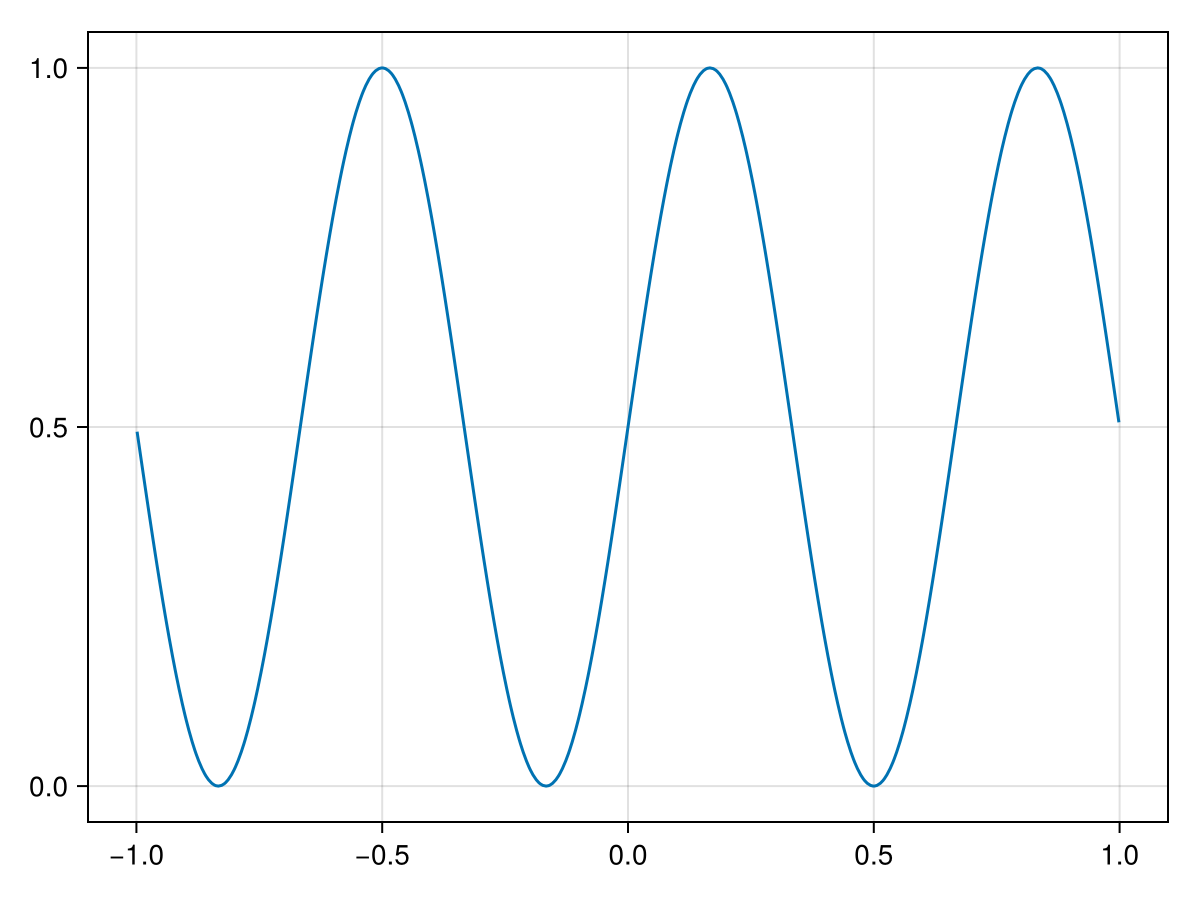

In [13]:
lines(xgrid, x0)

In [14]:
@time data = generate_data_trixi(model, x0, Tf, sys_burgers)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


 11.457792 seconds (38.75 M allocations: 2.580 GiB, 5.45% gc time, 94.96% compilation time)


SyntheticData([0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018000000000000002, 0.02  …  3.982, 3.984, 3.986, 3.988, 3.99, 3.992, 3.994, 3.996, 3.998, 4.0], 0.002, [0.4934563896573869, 0.4689173941833885, 0.4370225997681946, 0.4127450715138443, 0.39988966148727423, 0.3759585049420274, 0.34519359951990536, 0.3220375820269989, 0.3098693919682456, 0.2873938475030665  …  0.7126061524969327, 0.6901306080317535, 0.677962417973001, 0.6548064004800963, 0.6240414950579708, 0.6001103385127249, 0.5872549284861557, 0.5629774002318063, 0.5310826058166097, 0.5065436103426122], [0.49831680511818277 0.503627052262449 … 0.5445249627491527 0.5596463798171; 0.472447756701355 0.479254418506468 … 0.47405547875559667 0.48511961997571146; … ; 0.5358344578777262 0.5397820756468683 … 0.5928097674427055 0.5921420837107347; 0.5118350032116609 0.5148165743924618 … 0.5774433374392286 0.5847836924599784], [0.3083845114222886 0.373385800511257 … 0.500570993481778 0.5704504494039894; 0.03873600296894978 0

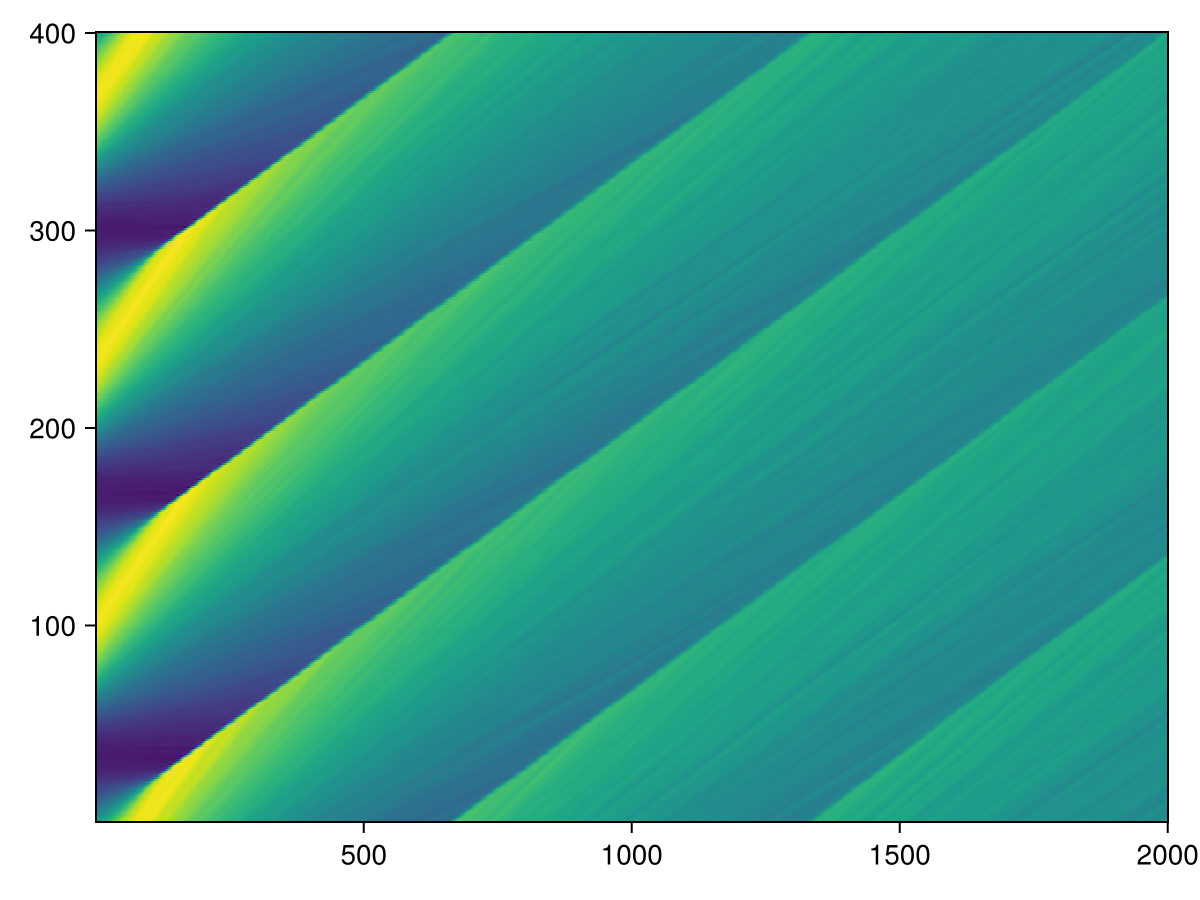

In [15]:
heatmap(data.xt[:, 1:end]')

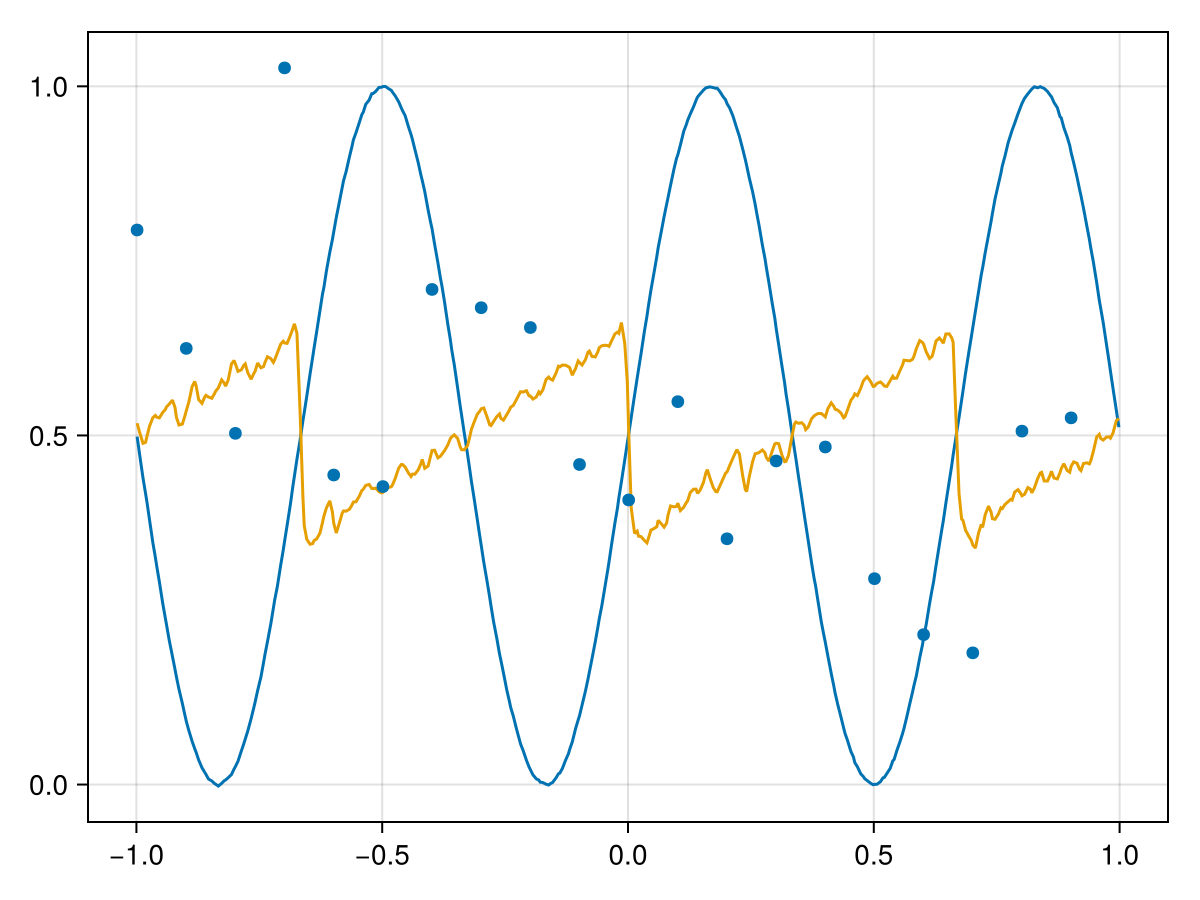

In [16]:
fig = Figure()
ax = Axis(fig[1,1])

lines!(ax, xgrid, data.xt[:,1])
lines!(ax, xgrid, data.xt[:,1000])
scatter!(ax, xgrid[1:Δ:end], data.yt[:,1000])

fig

In [17]:
norm(data.xt[:,1] .- mean(data.xt[:,1]))

7.070108551203029

In [18]:
norm(data.xt[:,1000] .- mean(data.xt[:,1000]))

1.6849241124149126

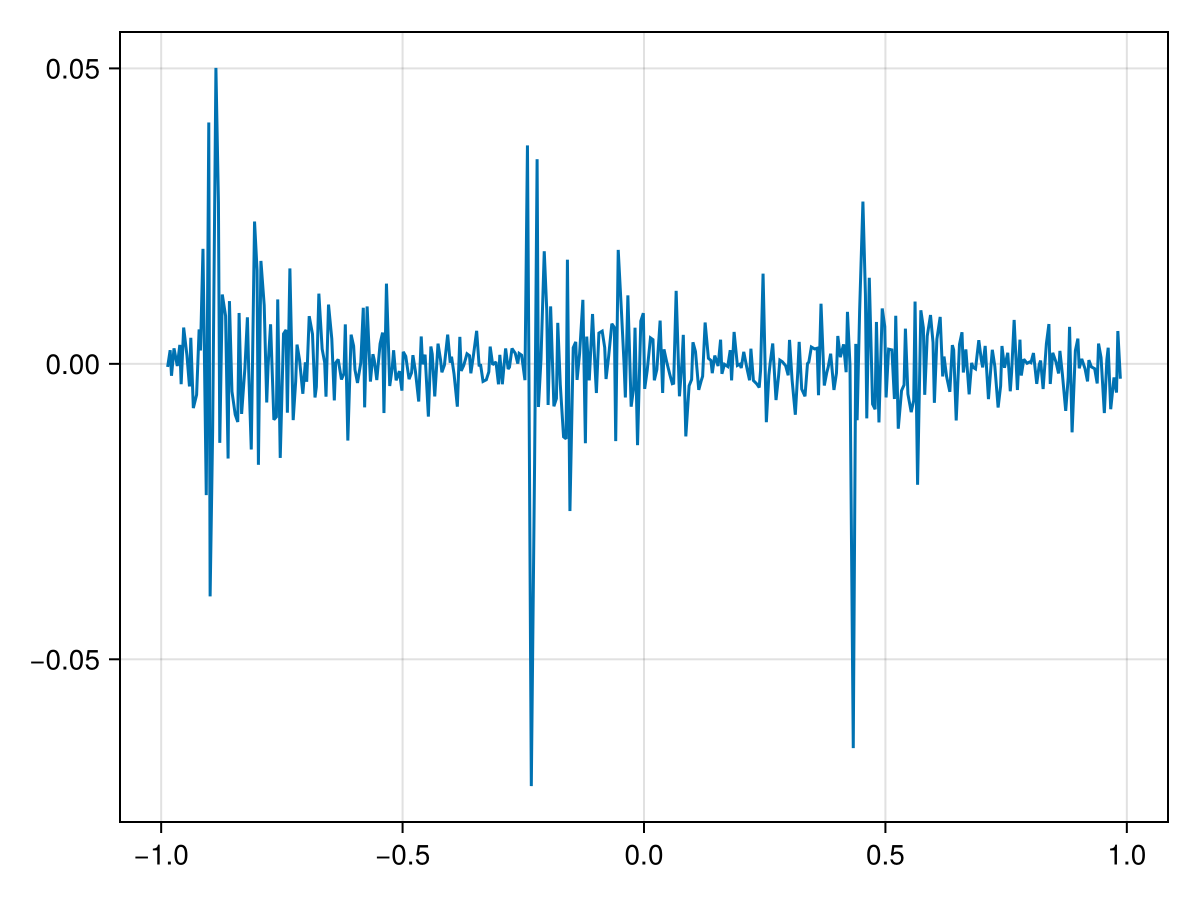

In [19]:
fig = Figure()
ax = Axis(fig[1,1])

# lines!(ax, xgrid, data.xt[:,1])
lines!(ax, xs, PA*data.xt[:,100])

fig

Define ObsConstraintSystem

In [51]:
idx = 4

## Selecion of hyper-prior parameters
# power parameter
r_range = [ 1.0, .5, -.5, -1.0 ]; 
r = r_range[idx] # select parameter 
# shape parameter
β_range = [ 1.501, 3.0918, 2.0165, 1.0017 ]; 
β = β_range[idx] # shape parameter
# rate parameters 
ϑ_range = [ 5*10^(-2), 5.9323*10^(-3), 1.2583*10^(-3), 1.2308*10^(-4) ]; 
ϑ = 5*10^(-3)#ϑ_range[idx]


# r = -0.5
# β = 0.5
# ϑ = 0.01
dist = GeneralizedGamma(r, β, ϑ);

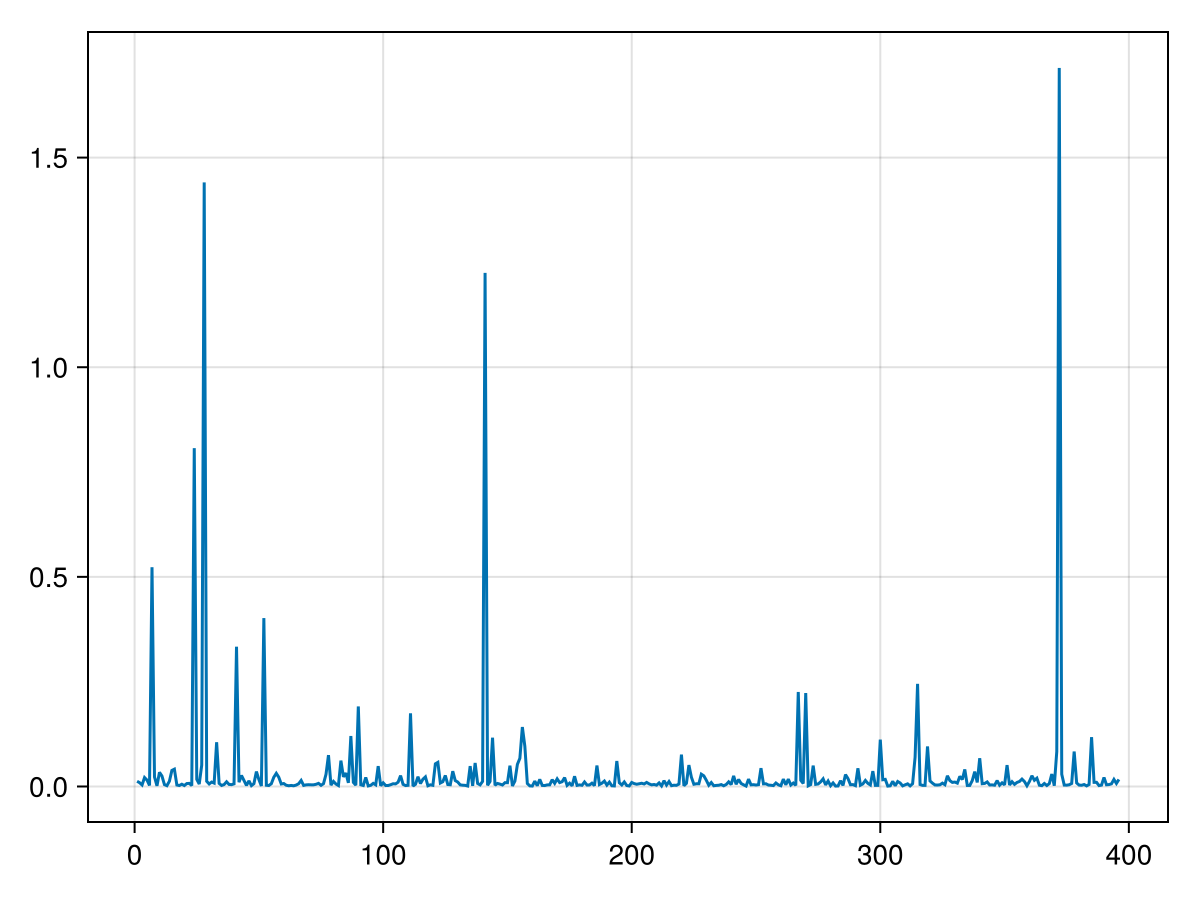

In [52]:
fig = Figure()

lines(rand(dist, Ns))

Create initial ensemble

In [53]:
Ne = 100
X = zeros(model.Ny + model.Nx, Ne)

for i=1:Ne
    regenerate!(f0)
    X[Ny+1:Ny+Nx,i] = f0.(xgrid)#initial_condition(αk, Δx, Nx)
end

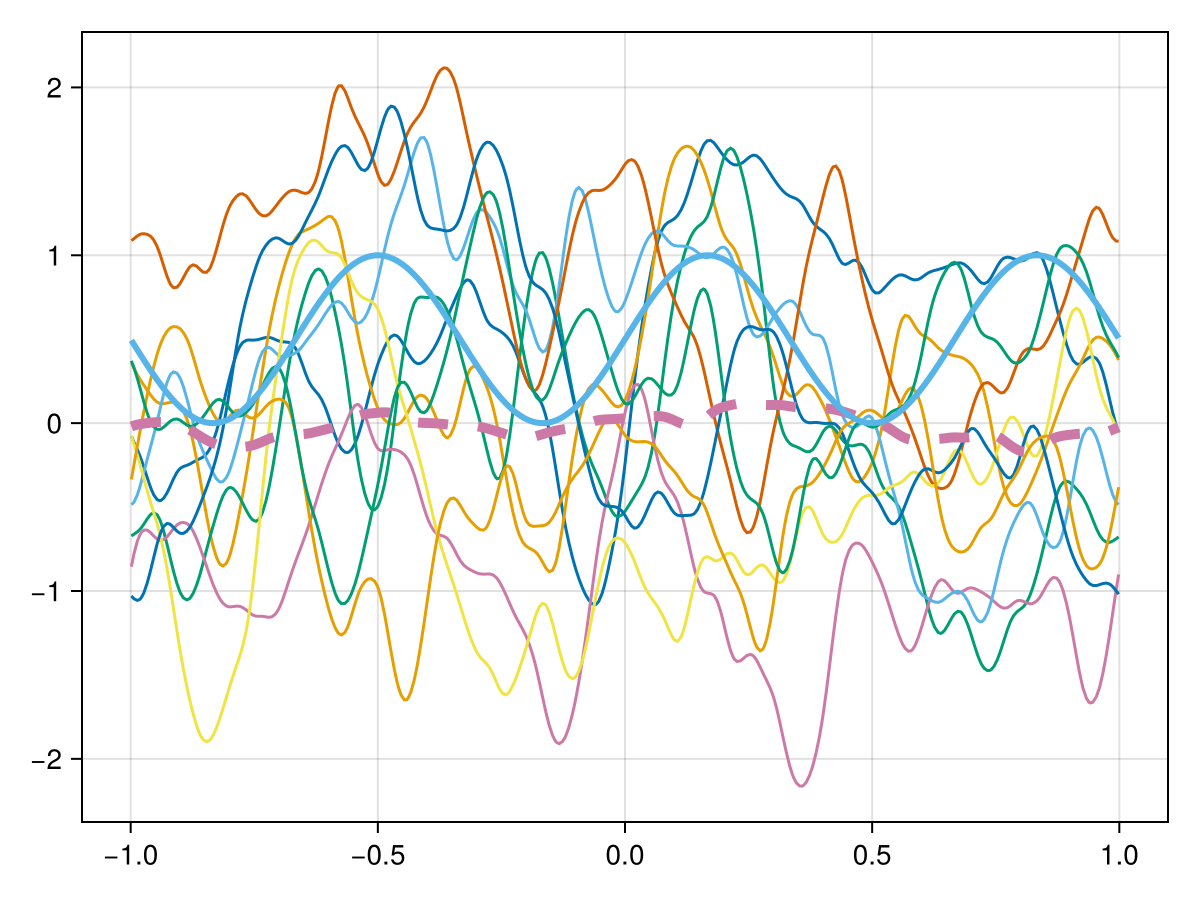

In [54]:
fig = Figure()

ax = Axis(fig[1,1])

for i=1:10
    lines!(ax, xgrid, X[Ny+1:Ny+Nx,i])
end
lines!(xgrid, mean(X[Ny+1:Ny+Nx,:]; dims = 2)[:,1], linewidth = 5, linestyle = :dash)

lines!(ax, xgrid, x0, linewidth = 3)

fig

Define initial guess

In [55]:
θinit = rand(dist, Ns);

Define linear maps and ObsConstraintSystem

In [56]:
Cθ = LinearMap(Diagonal(deepcopy(θinit)))
Cϵ = LinearMap(ϵy.Σ)
CX = LinearMap(Diagonal(1.0 .+ rand(Nx)))
sys_ys = ObsConstraintSystem(H, S, Cθ, Cϵ, CX)

ObsConstraintSystem(400, 20, 396, 20×400 LinearMaps.WrappedMap{Float64} of
  20×400 SparseMatrixCSC{Float64, Int64} with 20 stored entries, 396×400 LinearMaps.FunctionMap{Float64,true}(#1, #2; issymmetric=false, ishermitian=false, isposdef=false), 396×396 LinearMaps.WrappedMap{Float64} of
  396×396 Diagonal{Float64, Vector{Float64}}, 20×20 LinearMaps.WrappedMap{Float64} of
  20×20 Diagonal{Float64, Vector{Float64}}, LinearMap[400×400 LinearMaps.WrappedMap{Float64} of
  400×400 Diagonal{Float64, Vector{Float64}}])

In [57]:
sys_y = ObsSystem(H, Cϵ, CX)

ObsSystem(400, 20, 20×400 LinearMaps.WrappedMap{Float64} of
  20×400 SparseMatrixCSC{Float64, Int64} with 20 stored entries, 20×20 LinearMaps.WrappedMap{Float64} of
  20×20 Diagonal{Float64, Vector{Float64}}, LinearMap[400×400 LinearMaps.WrappedMap{Float64} of
  400×400 Diagonal{Float64, Vector{Float64}}])

In [58]:
yidx = 1:Δ:Nx
idx = vcat(collect(1:length(yidx))', collect(yidx)')

# @assert length(yidx) == Ny

# # Create Localization structure
Gxx(i,j) = periodicmetric!(i,j, Nx)
Gxy(i,j) = periodicmetric!(i,yidx[j], Nx)
Gyy(i,j) = periodicmetric!(yidx[i],yidx[j], Nx)

Lrad = 7
Loc = Localization(Lrad, Gxx, Gxy, Gxx)

Localization(7.0, Gxx, Gxy, Gxx)

In [59]:
β = 1.01
ϵxβ = MultiAddInflation(Nx, β, zeros(Nx), σx)

MultiAddInflation(400, 1.01, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0001 0.0 … 0.0 0.0; 0.0 0.0001 … 0.0 0.0; … ; 0.0 0.0 … 0.0001 0.0; 0.0 0.0 … 0.0 0.0001], [0.01 0.0 … 0.0 0.0; 0.0 0.01 … 0.0 0.0; … ; 0.0 0.0 … 0.01 0.0; 0.0 0.0 … 0.0 0.01])

Define EnKF

In [60]:
enkf = EnKF(Ne, ϵy, sys_y, Δtdyn, Δtobs)

Matrix-free implementation of the ensemble Kalman filter with filtered = false


Define localized EnKF

In [61]:
locenkf = LocEnKF(Ne, ϵy, sys_y, Loc, Δtdyn, Δtobs)

Localized ensemble Kalman filter with filtered = false


Define hierarchical EnKF

In [62]:
henkf = HEnKF(Ne, ϵy, sys_ys, dist, deepcopy(θinit), Δtdyn, Δtobs)

Hierarchical ensemble Kalman filter with filtered = false


Define hierarchical and localized EnKF

In [63]:
hlocenkf = HLocEnKF(Ne, ϵy, sys_ys, Loc, dist, deepcopy(θinit), Δtdyn, Δtobs)

Hierarchical localized ensemble Kalman filter with filtered = false


In [64]:
X_enkf = seqassim_trixi(data, Tf, ϵxβ, enkf, deepcopy(X), model.Ny, model.Nx, t0, sys_burgers);

Progress: 100%|█████████████████████████████████████████| Time: 0:02:54


In [65]:
X_locenkf = seqassim_trixi(data, Tf, ϵxβ, locenkf, deepcopy(X), model.Ny, model.Nx, t0, sys_burgers);

Progress: 100%|█████████████████████████████████████████| Time: 0:02:58


In [66]:
# X_henkf, θ_henkf = seqassim_trixi(data, Tf, ϵxβ, henkf, deepcopy(X), model.Ny, model.Nx, t0, sys_burgers);

In [67]:
X_hlocenkf, θ_hlocenkf = seqassim_trixi(data, Tf, ϵxβ, hlocenkf, deepcopy(X), model.Ny, model.Nx, t0, sys_burgers);

Progress: 100%|█████████████████████████████████████████| Time: 0:23:38


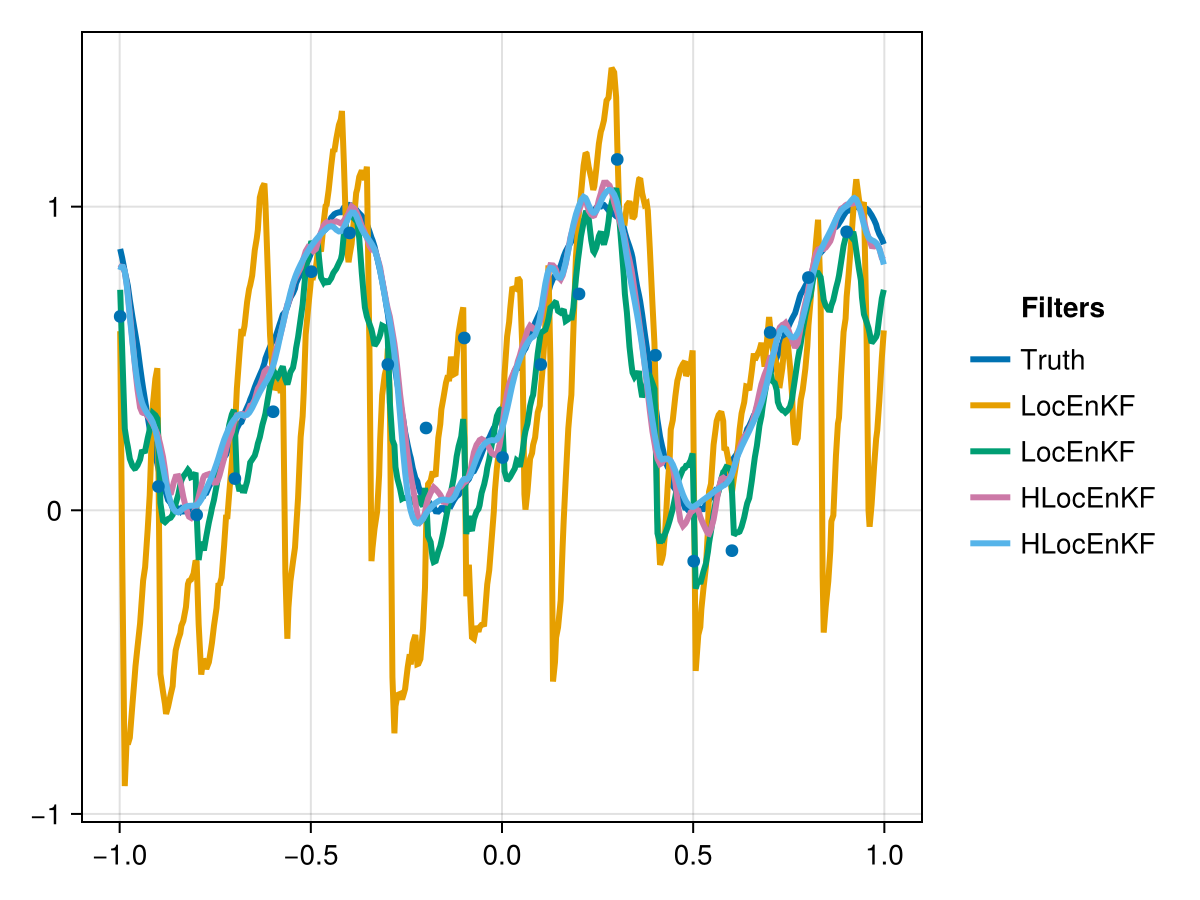

In [45]:
fig = Figure()

ax = Axis(fig[1,1])

tsnap = 50
idx = 10

lines!(ax, xgrid, data.xt[:,tsnap], linewidth = 3, label = "Truth")

# lines!(ax, xgrid, X[Ny+1:Ny+Nx,2])
# lines!(ax, xgrid, X_enkf[tsnap+1][:,idx], linewidth = 3, label = "EnKF")
# lines!(ax, xgrid, mean(X_enkf[tsnap+1]; dims = 2)[:,1], linewidth = 3, label = "EnKF")

lines!(ax, xgrid, X_locenkf[tsnap+1][:,idx], linewidth = 3, label = "LocEnKF")
lines!(ax, xgrid, mean(X_locenkf[tsnap+1]; dims = 2)[:,1], linewidth = 3, label = "LocEnKF")


# lines!(ax, xgrid, X_henkf[tsnap+1][:,2], linewidth = 3, label = "HEnKF")
# lines!(ax, xgrid, X_henkf[tsnap+1][:,2])
# lines!(ax, xgrid, mean(X_henkf[tsnap+1]; dims = 2)[:,1], linewidth = 3, label = "HEnKF")

lines!(ax, xgrid, X_hlocenkf[tsnap+1][:,idx], linewidth = 3, label = "HLocEnKF")
lines!(ax, xgrid, mean(X_hlocenkf[tsnap+1]; dims = 2)[:,1], linewidth = 3, label = "HLocEnKF")

# ax2 = Axis(fig[1,2])

fig[1, 2] = Legend(fig, ax, "Filters", framevisible = false)

# lines!(ax, xgrid[1:2:end], data.yt[:,tsnap], linewidth = 3)


scatter!(ax, xgrid[1:Δ:end], data.yt[:,tsnap])
# lines!(ax, xs, PA.P*X_enkf[tsnap+1][:,2])


fig

In [46]:
data.xt

400×2000 Matrix{Float64}:
 0.498317  0.503627  0.5072    0.509967  …  0.530549  0.544525  0.559646
 0.472448  0.479254  0.484909  0.490938     0.464544  0.474055  0.48512
 0.439094  0.442154  0.446832  0.450879     0.440641  0.441353  0.442705
 0.416828  0.419453  0.422693  0.424938     0.440869  0.438907  0.439309
 0.404857  0.409117  0.41324   0.416256     0.433873  0.437161  0.43881
 0.379417  0.383263  0.387469  0.390529  …  0.422295  0.421896  0.422844
 0.346541  0.350565  0.35504   0.35855      0.43676   0.433807  0.430305
 0.325191  0.328474  0.33027   0.332997     0.450773  0.449665  0.446323
 0.3126    0.315673  0.31929   0.321331     0.459864  0.455825  0.453656
 0.290824  0.293649  0.296912  0.299453     0.470691  0.470133  0.468402
 0.260165  0.261818  0.264474  0.267425  …  0.450336  0.454218  0.45666
 0.239272  0.240423  0.242594  0.244168     0.428038  0.430378  0.435967
 0.228379  0.230062  0.231203  0.234746     0.419984  0.420075  0.423513
 ⋮                          

In [47]:
rmse_locenkf = mean(map(i->norm(data.xt[:,i]-mean(X_locenkf[i+1]; dims = 2))/sqrt(Nx), 1:Tf))

0.06549129328531175

In [48]:
spread_locenkf = mean(map(i->spread(X_locenkf[i+1]), 1:Tf))

0.18991675138336153

In [49]:
rmse_hlocenkf = mean(map(i->norm(data.xt[:,i]-mean(X_hlocenkf[i+1]; dims = 2))/sqrt(Nx), 1:Tf))

0.03308397146852263

In [50]:
spread_hlocenkf = mean(map(i->spread(X_hlocenkf[i+1]), 1:Tf))

0.019365211612801435

In [ ]:
tsnap = Observable(1)

x_tsnap = @lift(hcat(data.x0, data.xt)[:,$(tsnap)])
y_tsnap = @lift(hcat(zeros(Ny), data.yt)[:,$(tsnap)])
X_locenkf_tsnap = @lift(mean(X_locenkf[$tsnap]; dims = 2)[:,1])
X_hlocenkf_tsnap = @lift(mean(X_hlocenkf[$tsnap]; dims = 2)[:,1])

scaled_θ_hlocenkf_tsnap = @lift(θ_hlocenkf[$tsnap] / norm(θ_hlocenkf[$tsnap]))


fig = Figure()

ax1 = Axis(fig[1,1])

lines!(ax1, xgrid, x_tsnap, linewidth = 3, label = "Truth")
lines!(ax1, xgrid, X_locenkf_tsnap, linewidth = 3, label = "LocEnKF")
lines!(ax1, xgrid, X_hlocenkf_tsnap, linewidth = 3, label = "HLocEnKF", linestyle =:dashdot)
scatter!(ax1, xgrid[1:Δ:end], y_tsnap, color = :grey)

axislegend(ax1)

ax2 = Axis(fig[1,2])

lines!(ax2, xs, scaled_θ_hlocenkf_tsnap, linewidth = 3, label = L"θ")
ylims!(ax2, 0.0, 0.6)

framerate = 10
timestamps = range(1, 101, step = 1)

record(fig, "inviscid_burgers.mp4", timestamps; framerate = framerate) do t
    tsnap[] = t
end

In [ ]:
time = Observable(0.0)

x1i = @lift(vcat(map(i->sim.u[i]($time)[1], 1:Ne)...))
x2i = @lift(vcat(map(i->sim.u[i]($time)[2], 1:Ne)...))

idx_color_tab = zeros(Int64, Ne)

for i=1:Ne
    x0i = sim.u[i](0.0)
    idx_color_tab[i] = ceil(Int64, phase_coloring(x0i, ColorSchemes.phase))
end


fig, axis, scatterplot = scatter(x1i, x2i, markersize = 20, color = ColorSchemes.phase[idx_color_tab], 
            fontsize = 20, 
            axis = (
            aspect = 1.0,
            title = @lift("t = $(round($time, digits = 1))"),
#             title =  @lift("t = $(time"),
            xlabel = L"x_1", 
            ylabel = L"x_2"))

CairoMakie.xlims!(axis, [-5.0, 5.0])
CairoMakie.ylims!(axis, [-5.0, 5.0])

framerate = 30
timestamps = range(0, tf, step=1/framerate)

record(fig, "spiral2D_animation.mp4", timestamps; framerate = framerate) do t
    time[] = t
end

In [ ]:
mean(std(X_hlocenkf[50]; dims = 2))

In [ ]:
mean(std(X_locenkf[50]; dims = 2))

In [ ]:
fig = Figure()

ax = Axis(fig[1,1])

tsnap = 80

# lines!(ax, xs, θ_henkf[tsnap])
lines!(ax, xs, θ_hlocenkf[tsnap])


fig